In [1]:
params_notebook_name = "datasets.eclip.py.ipynb"
params_resource_dir = "../resources/"
params_subset_chroms = [
    "chr12",
]

params_subset_rbp_cl = [
    "QKI_HepG2",
    "QKI_K562",
    "PTBP1_HepG2",
    "SRSF7_HepG2",
]

params_tmp_dir = None

# Datasets - eCLIP datasets

## Overview

## Imports

In [ ]:
import dataclasses
import os
import sys
import tempfile
from dataclasses import asdict
from io import StringIO
from numbers import Number
from pathlib import Path
from typing import Literal, Optional

import numpy as np
import pandas as pd
import pybedtools as pbt
import pyBigWig as pbw
import pydantic.dataclasses
import pyfaidx
import requests
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from dotenv import find_dotenv, load_dotenv
from dotmap import DotMap
from IPython.display import HTML, SVG, Image, display
from pydantic.dataclasses import dataclass
from snakemake.io import glob_wildcards

In [4]:
import matplotlib as mpl
import matplotlib.font_manager
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

try:
    matplotlib.font_manager.findfont("Arial")
    mpl.rcParams["font.sans-serif"] = ["Arial"]
except Exception as e:
    print("Setting Arial font failed in some way...")
    print(e)

rc("text", usetex=False)

In [5]:
def assert_notebook_working_dir(expected_local_file: os.PathLike) -> Path:
    """Assert or try updating the current working directory to where the notebook is located, to enable relative paths references.

    This function is used in a set-up where notebooks are contained within a project
    directory structure in which we want to reference filepaths relative to the notebook.
    e.g. "../src" or "../resources" should be accessible if the notebook is in
    "../notebooks/<notebook_name>.ipynb".

    The function first check the filepath of the expected local file relative
    to the current working directory.

    If not found, the function will try to use the VSCode Jupyter variable `__vsc_ipynb_file__`
    which should report the path of the notebook file being executed.

    It then checks if the expected local file exists, relative to the new working directory.


    Args:
        expected_local_file (os.PathLike): The expected local file to check for in the current working directory.
            This can be the name of the notebook file.

    Raises:
        KeyError: if the `__vsc_ipynb_file__` variable is not found in the global scope, while the first CWD check failed.
        FileNotFoundError: if the expected local file is not found in the current working directory after attempting to change it.
    """
    import os
    from pathlib import Path

    cwd = Path(os.getcwd())
    expected_local_filepath = cwd / expected_local_file

    if not expected_local_filepath.exists():
        if "__vsc_ipynb_file__" not in globals():
            raise KeyError(
                f"Detected CWD: {cwd} ; CWD does not contain expected file, but cannot use __vsc_ipynb_file__ to recover."
            )
        else:
            os.chdir(Path(globals()["__vsc_ipynb_file__"]).parent)
            cwd = Path(os.getcwd())
            print(f"Changed CWD to {cwd}")

            expected_local_filepath = cwd / expected_local_file
            if not expected_local_filepath.exists():
                raise FileNotFoundError(
                    f"Updated (using __vsc_ipynb_file__) CWD: {cwd} ; CWD does not contain expected file."
                )

            return cwd
    else:
        print(f"Confirmed CWD: {cwd} contains expected file: {expected_local_file}")
        return cwd


expected_local_file: str = params_notebook_name
cwd = assert_notebook_working_dir(expected_local_file=expected_local_file)
print(cwd)

Confirmed CWD: /home/l10n/projects/ml4rg25-parnet/parnet_demo/notebooks contains expected file: datasets.eclip.py.ipynb
/home/l10n/projects/ml4rg25-parnet/parnet_demo/notebooks


## Definitions

In [48]:
@dataclass
class GenomicInterval:
    chrom: str
    start: int
    end: int
    name: str
    score: int | float | str
    strand: Literal["+", "-"]

    def __post_init__(self):
        # Enforce [0, end) interval.
        if self.start < 0:
            raise ValueError(f"Start position {self.start} must be non-negative.")
        if self.start >= self.end:
            raise ValueError(f"Start position {self.start} must be less than end position {self.end}.")


## Initialization

In [6]:
# Env variables, defined in the `.env` file at the root of the project directory.
load_dotenv(find_dotenv(), override=True)

False

In [7]:
resource_dir = Path(params_resource_dir)
if not resource_dir.exists():
    raise FileNotFoundError("Resource directory does not exist: " + str(resource_dir))

print("Using resources from:", resource_dir)

Using resources from: ../resources


In [8]:
bed6_cols = ["chrom", "start", "end", "name", "score", "strand"]

In [9]:
# Caution: pyBedTools relies on tmp dir, which can get quite large.
def create_randomized_tmp_dir(parent_dir: os.PathLike | None = None) -> str:
    # Get the parent tmp dir where to create a randomized tmp dir.

    parent_tmp_dir = None

    # Default system value
    parent_tmp_dir = Path(tempfile.gettempdir())
    if params_tmp_dir is not None:
        parent_tmp_dir = Path(params_tmp_dir)

    if os.getenv("TMP_DIR") is not None:
        parent_tmp_dir = Path(os.getenv("TMP_DIR"))

    if os.getenv("TMP") is not None:
        parent_tmp_dir = Path(os.getenv("TMP"))

    if parent_tmp_dir is None:
        raise ValueError("No temporary directory specified or found.")

    # Test write access to the parent tmp dir
    if not parent_tmp_dir.is_dir():
        raise NotADirectoryError(f"Parent tmp dir is not a directory: {parent_tmp_dir}")

    if not os.access(parent_tmp_dir, os.W_OK):
        raise PermissionError(f"Parent tmp dir is not writable: {parent_tmp_dir}")

    # Make a randomized tmp dir
    tmp_dir = tempfile.mkdtemp(dir=parent_tmp_dir)
    return tmp_dir


tmp_dir = create_randomized_tmp_dir()
print("Using temporary directory for pyBedTools:", tmp_dir)

pbt.set_tempdir(tmp_dir)

Using temporary directory for pyBedTools: /tmp/tmprnbt0klp


## Load general datasets

### Genome data

In [75]:
genome_size_filepath = resource_dir / "general" / "genome" / "hg38.chrom.sizes"
print('Loading the "genome file" from:', genome_size_filepath)

genome_file = pd.read_csv(genome_size_filepath, header=None, sep="\t")
genome_file.columns = ["chrom", "size"]

main_autosomes = [f"chr{i}" for i in range(1, 23)]
sex_chromosomes = ["chrX", "chrY"]
mitochondrial_chromosome = ["chrM"]
main_chromosomes = list(set(main_autosomes) | set(sex_chromosomes) | set(mitochondrial_chromosome))


Loading the "genome file" from: ../resources/general/genome/hg38.chrom.sizes


In [11]:
# We also load the genome FASTA file, to demonstrate basic sequence enrichment analysis.
fa = pyfaidx.Fasta(resource_dir / "general" / "genome" / "hg38.fa.gz")

### Gene annotations

We will load MANE reference transcripts and genome chrom sizes to define ranges of regions to look into.

In [12]:
filepath = (
    resource_dir / "general" / "gene_annotations.hg38.MANE_v1.4" / "MANE.GRCh38.v1.4.ensembl_genomic.transcripts.bed.gz"
)

# Rather than load the file, we will query it with bedtools,
bt_transcripts = pbt.BedTool(filepath)
bt_transcripts = bt_transcripts.tabix()

bt_genome = pbt.BedTool.from_dataframe(
    genome_file.loc[lambda df: df["chrom"].isin(params_subset_chroms), :]
    .assign(start=0, end=lambda df: df["size"])
    .loc[:, ["chrom", "start", "end"]]
)

mane_transcripts = bt_transcripts.intersect(bt_genome).to_dataframe()

In [13]:
display(mane_transcripts.head(3))
print("Number of MANE transcripts:", len(mane_transcripts))

,chrom,start,end,name,score,strand
0,chr12,66766,178455,ENST00000538872.6,.,+
1,chr12,190080,214157,ENST00000684302.1,.,-
2,chr12,220621,262836,ENST00000343164.9,.,-


Number of MANE transcripts: 1008


We also load the GENCODE datasets:

- gene metadata table
- gene type metadata table
- non-overlapping, biotype annotated intervals for plus and minus strands

In [14]:
filepath = resource_dir / "general" / "gene_annotations.hg38.gencode_v40" / "gene_metadata.tsv.gz"
gencode_gene_metadata = pd.read_csv(filepath, sep="\t", compression="gzip", header=0)
display(gencode_gene_metadata.head(3))

,transcript_id,gene_id,gene_name,gene_type,protein_id,official_name,official_id
0,ENST00000456328.2,ENSG00000223972.5,DDX11L1,transcribed_unprocessed_pseudogene,NaN,DDX11L1,HGNC:37102
1,ENST00000450305.2,ENSG00000223972.5,DDX11L1,transcribed_unprocessed_pseudogene,NaN,DDX11L1,HGNC:37102
2,ENST00000488147.1,ENSG00000227232.5,WASH7P,unprocessed_pseudogene,NaN,WASH7P,HGNC:38034


In [16]:
filepath = resource_dir / "general" / "gene_annotations.hg38.gencode_v40" / "simplified_grouped_genetype.tsv"
gencode_genetype_metadata = pd.read_csv(filepath, sep="\t", header=0)
display(gencode_genetype_metadata.head(3))

,genetype,simplified_genetype,group_genetype
0,IG_C_gene,IG_TR_gene,protein_coding
1,IG_D_gene,IG_TR_gene,protein_coding
2,IG_J_gene,IG_TR_gene,protein_coding


In [17]:
filepath_minus = (
    resource_dir / "general" / "gene_annotations.hg38.gencode_v40" / "complete.non-overlap.annotated.minus.bed.gz"
)
filepath_plus = (
    resource_dir / "general" / "gene_annotations.hg38.gencode_v40" / "complete.non-overlap.annotated.plus.bed.gz"
)

# Rather than load the complete files, we apply again bedtools to query the files.
# NOTE: here you can see that a "BedTool" object can be created from a filepath,
# rather than from a loaded pandas DataFrame.
gencode_minus = pbt.BedTool(filepath_minus).intersect(bt_genome).to_dataframe()
gencode_plus = pbt.BedTool(filepath_plus).intersect(bt_genome).to_dataframe()

display(gencode_minus.head(3))
display(gencode_plus.head(3))
print(f"Number of GENCODE minus strand intervals: {len(gencode_minus):_}")
print(f"Number of GENCODE plus strand intervals: {len(gencode_plus):_}")

,chrom,start,end,name,score,strand
0,chr12,36601,38133,lncRNA;FAM138D;lncRNA;ENSG00000249054.2,.,-
1,chr12,106523,111850,lncRNA;ENSG00000256948;lncRNA;ENSG00000256948.1,.,-
2,chr12,137410,149169,lncRNA;ENSG00000249695;lncRNA;ENSG00000249695.6,.,-


,chrom,start,end,name,score,strand
0,chr12,66766,66882,five_prime_UTR;IQSEC3;protein_coding;ENSG00000...,.,+
1,chr12,66882,66885,start_codon;IQSEC3;protein_coding;ENSG00000120...,.,+
2,chr12,66885,67436,CDS;IQSEC3;protein_coding;ENSG00000120645.12,.,+


Number of GENCODE minus strand intervals: 26_540
Number of GENCODE plus strand intervals: 26_688


## eCLIP data - read counts

Here we load `bigwig` files, a binary format for storing one numeric value per position
in a genomic coordinate system.

This format can be manually built from a `Wiggle` file format, using the command `wigToBigWig <in.wig> <genome.chrom.sizes> <out.bw>`.

Check the specification of the `Wiggle` format [here](https://genome.ucsc.edu/goldenPath/help/wiggle)

The simplest version below shows a header line defining a fixed-step size of 1 nucleotide, starting at position 1 (wiggle format is 1-based) or chromosome 1.

```bash
fixedStep  chrom="chr1" start=1  step=1`
0.1
0.2
...
```

This can be useful for creating your own `bigwig` files, for example from PARNET predictions.

Hereafter we demonstrate how to manipulate `bigwig` files using the `pyBigWig` library.

On the available files:

- each eCLIP experiment is performed on a specific RNA Binding Protein (e.g. `QKI`) in a specific Cell Line (e.g. `HepG2`).

- each experiment has
    - 2 biological replicates for the *eCLIP* (i.e. the data generated from the part of the protocol where the RBP is actually immunoprecipitated),
    - and 1 biological replicate for the *input* (i.e. the data generated from the part of the protocol where no RBP is immunoprecipitated).

- for training PARNET, the two biological replicates of the *eCLIP* are summed position-wise into a single file. Keeping the two replicate separate here allows to compare between-replicate correlation vs prediction-vs-replicate correlation.

- For now, we will simply demonstrate how to load the data.

#### Load

In [ ]:
LIST_ECLIP_STRAND: list[Literal["pos", "neg"]] = ["pos", "neg"]
LIST_ECLIP_REPLICATE: list[Literal["1", "2"]] = ["1", "2"]
LIST_SUBSET_RBP_CL: list[str] = params_subset_rbp_cl

parent_dir_bigwig = resource_dir / "parnet_encore_eclip" / "bigwig_processed_counts"

# List the content of the directory to get the list of "{RBP_CL}" e.g. "QKI_K562", "PTBP1_HepG2", etc.
LIST_RBP_CL = sorted(os.listdir(parent_dir_bigwig))

ufmt_readcounts_eclip_fp = parent_dir_bigwig / "{RBP_CL}" / "eCLIP" / "{REPLICATE}" / "counts.{STRAND}.bw"

ufmt_readcounts_control_fp = parent_dir_bigwig / "{RBP_CL}" / "control" / "counts.{STRAND}.bw"

In [25]:
# Here we use a function that automatically identifies the possible values for "wildcards" in a filepath.

compiled_experiments: list[tuple[str, str, str]] = []

for RBP_CL in LIST_RBP_CL:
    for REPLICATE in LIST_ECLIP_REPLICATE:
        for STRAND in LIST_ECLIP_STRAND:
            compiled_experiments.append((RBP_CL, REPLICATE, STRAND))

df_experiments = pd.DataFrame(compiled_experiments, columns=["RBP_CL", "REPLICATE", "STRAND"])
split_rbp_cl = df_experiments["RBP_CL"].str.split("_", expand=True).set_axis(["RBP", "CL"], axis=1)
df_experiments = pd.concat([df_experiments, split_rbp_cl], axis=1)
df_experiments = df_experiments.sort_values(by=["RBP", "CL"], ascending=[True, True])

display(df_experiments.head(3))
print(df_experiments.shape)

df_experiments = df_experiments.loc[lambda df: df["RBP_CL"].isin(params_subset_rbp_cl), :].reset_index(drop=True)

print("Subsetted experiments to the following RBP_CLs:", params_subset_rbp_cl)
display(df_experiments.head(3))
print(df_experiments.shape)

,RBP_CL,REPLICATE,STRAND,RBP,CL
0,AARS_K562,1,pos,AARS,K562
1,AARS_K562,1,neg,AARS,K562
2,AARS_K562,2,pos,AARS,K562


(892, 5)
Subsetted experiments to the following RBP_CLs: ['QKI_HepG2', 'QKI_K562', 'PTBP1_HepG2', 'SRSF7_HepG2']


,RBP_CL,REPLICATE,STRAND,RBP,CL
0,PTBP1_HepG2,1,pos,PTBP1,HepG2
1,PTBP1_HepG2,1,neg,PTBP1,HepG2
2,PTBP1_HepG2,2,pos,PTBP1,HepG2


(16, 5)


In [35]:
data_eclip_signal = DotMap()

for _, row in df_experiments.iterrows():
    print(row.to_dict())
    readcounts_eclip_fp = str(ufmt_readcounts_eclip_fp).format(
        RBP_CL=row["RBP_CL"], REPLICATE=row["REPLICATE"], STRAND=row["STRAND"]
    )
    data_eclip = pbw.open(readcounts_eclip_fp)
    data_eclip_signal[row["RBP_CL"]]["eCLIP"][row["REPLICATE"]][row["STRAND"]] = data_eclip

    # NOTE: this could be optimized as, we load twice the same "control" track,
    # since for each RBP_CL and STRAND we have two replicates, while there is only one control track.

    readcounts_control_fp = str(ufmt_readcounts_control_fp).format(RBP_CL=row["RBP_CL"], STRAND=row["STRAND"])
    data_control = pbw.open(readcounts_control_fp)
    data_eclip_signal[row["RBP_CL"]]["control"][row["STRAND"]] = data_control

{'RBP_CL': 'PTBP1_HepG2', 'REPLICATE': '1', 'STRAND': 'pos', 'RBP': 'PTBP1', 'CL': 'HepG2'}
{'RBP_CL': 'PTBP1_HepG2', 'REPLICATE': '1', 'STRAND': 'neg', 'RBP': 'PTBP1', 'CL': 'HepG2'}
{'RBP_CL': 'PTBP1_HepG2', 'REPLICATE': '2', 'STRAND': 'pos', 'RBP': 'PTBP1', 'CL': 'HepG2'}
{'RBP_CL': 'PTBP1_HepG2', 'REPLICATE': '2', 'STRAND': 'neg', 'RBP': 'PTBP1', 'CL': 'HepG2'}
{'RBP_CL': 'QKI_HepG2', 'REPLICATE': '1', 'STRAND': 'pos', 'RBP': 'QKI', 'CL': 'HepG2'}
{'RBP_CL': 'QKI_HepG2', 'REPLICATE': '1', 'STRAND': 'neg', 'RBP': 'QKI', 'CL': 'HepG2'}
{'RBP_CL': 'QKI_HepG2', 'REPLICATE': '2', 'STRAND': 'pos', 'RBP': 'QKI', 'CL': 'HepG2'}
{'RBP_CL': 'QKI_HepG2', 'REPLICATE': '2', 'STRAND': 'neg', 'RBP': 'QKI', 'CL': 'HepG2'}
{'RBP_CL': 'QKI_K562', 'REPLICATE': '1', 'STRAND': 'pos', 'RBP': 'QKI', 'CL': 'K562'}
{'RBP_CL': 'QKI_K562', 'REPLICATE': '1', 'STRAND': 'neg', 'RBP': 'QKI', 'CL': 'K562'}
{'RBP_CL': 'QKI_K562', 'REPLICATE': '2', 'STRAND': 'pos', 'RBP': 'QKI', 'CL': 'K562'}
{'RBP_CL': 'QKI_K562',

#### Single example

In [36]:
# We will work with a random genomic annotation for now.
# NOTE: GAPDH is selected because highly expressed in HepG2 cell lines.
example_interval = GenomicInterval(
    chrom="chr12",
    start=6_538_170,
    end=6_538_371,
    name="three_prime_UTR;GAPDH;ENST00000229239.10",
    score=".",
    strand="+",
)

In [49]:
# We store in this dictionary the results ; the keys will be {RBP_CL}.{ECLIP_OR_CONTROL}[.{REPLICATE}]
# e.g. QKI_HepG2_eCLIP_1 for the eCLIP signal from replicate 1
queried_results: dict[str, list[float]] = {}

eclip_strand_str_mapping = {
    "+": "pos",
    "-": "neg",
}

for RBP_CL in params_subset_rbp_cl:
    for REPLICATE in LIST_ECLIP_REPLICATE:
        name = f"{RBP_CL}.control"
        control_signal_bw = data_eclip_signal[RBP_CL]["control"][eclip_strand_str_mapping[example_interval.strand]]

        queried_control_signal = control_signal_bw.values(
            example_interval.chrom, example_interval.start, example_interval.end
        )
        queried_results[name] = queried_control_signal

        for replicate in LIST_ECLIP_REPLICATE:
            name = f"{RBP_CL}.eCLIP.{REPLICATE}"
            eclip_signal_bw = data_eclip_signal[RBP_CL]["eCLIP"][REPLICATE][
                eclip_strand_str_mapping[example_interval.strand]
            ]

            queried_results[name] = eclip_signal_bw.values(
                example_interval.chrom, example_interval.start, example_interval.end
            )

queried_results_df = pd.DataFrame(queried_results)

In [50]:
queried_results_df

,QKI_HepG2.control,QKI_HepG2.eCLIP.1,QKI_HepG2.eCLIP.2,QKI_K562.control,QKI_K562.eCLIP.1,QKI_K562.eCLIP.2,PTBP1_HepG2.control,PTBP1_HepG2.eCLIP.1,PTBP1_HepG2.eCLIP.2,SRSF7_HepG2.control,SRSF7_HepG2.eCLIP.1,SRSF7_HepG2.eCLIP.2
0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
1,1.0,2.0,NaN,4.0,NaN,1.0,1.0,NaN,2.0,NaN,NaN,NaN
2,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
# The signal is rather sparse.
queried_results_df.isna().sum(axis=0).sort_values()

QKI_K562.control       100
QKI_HepG2.control      147
PTBP1_HepG2.eCLIP.1    169
PTBP1_HepG2.eCLIP.2    169
QKI_HepG2.eCLIP.1      174
PTBP1_HepG2.control    175
QKI_K562.eCLIP.2       182
SRSF7_HepG2.control    186
QKI_K562.eCLIP.1       191
QKI_HepG2.eCLIP.2      193
SRSF7_HepG2.eCLIP.1    198
SRSF7_HepG2.eCLIP.2    198
dtype: int64

## eCLIP - peaks

### Load

Peaks are genomic intervals representing boundaries within the eCLIP counts data that are likely to represent 
true binding events of an RBP onto an RNA.

Different tools exist to "call" peaks from read counts data. 

Here we use peaks that were called with the `pureCLIP` tool. 

This tool considers both replicates for a given RBP+cell line experiment, as well as the control input data.


Hence we have a single peak file per RBP+cell line experiment.

In [52]:
LIST_SUBSET_RBP_CL: list[str] = params_subset_rbp_cl

parent_dir_peaks = resource_dir / "parnet_encore_eclip" / "bed6_peaks_pureclip"

# List the content of the directory to get the list of "{RBP_CL}" e.g. "QKI_K562", "PTBP1_HepG2", etc.
LIST_RBP_CL = sorted(os.listdir(parent_dir_peaks))

ufmt_peaks_fp = parent_dir_peaks / "{RBP_CL}" / "peaks.crosslink.bed6"

In [53]:
data_eclip_peaks = DotMap()

for RBP_CL in set(LIST_SUBSET_RBP_CL) & set(LIST_RBP_CL):
    print("Loading peaks for RBP_CL:", RBP_CL)
    readcounts_peaks_fp = str(ufmt_peaks_fp).format(RBP_CL=RBP_CL)

    # NOTE : rather than loading the file into a dataframe, we can use pyBedTool to build
    # a BedTool object. This provides with an interface to query the content of the file.
    data_eclip_peaks[RBP_CL] = pbt.BedTool(readcounts_peaks_fp)


Loading peaks for RBP_CL: SRSF7_HepG2
Loading peaks for RBP_CL: QKI_HepG2
Loading peaks for RBP_CL: QKI_K562
Loading peaks for RBP_CL: PTBP1_HepG2


In [56]:
# We can display the filepath of a BedTool object.
print("BedTool object filepath:", data_eclip_peaks[RBP_CL].fn)
# We can display the content of the BedTool object.
print("BedTool object content:")
print(data_eclip_peaks[RBP_CL].head(3))

BedTool object filepath: ../resources/parnet_encore_eclip/bed6_peaks_pureclip/PTBP1_HepG2/peaks.crosslink.bed6
BedTool object content:
chr1	630716	630717	3	58.4343	+
 chr1	630717	630718	3	8.10339	+
 chr1	1037609	1037610	3	0.363269	+
 None


IMPORTANT: here you can see that the intervals are of length = 1.

This is because the PureCLIP tool actually has returned **cross-link sites** i.e. single-nucleotide events 
most likely representing where the RBP was "glued" to the RNA.



### Demo: intersection with example interval

#### Cross-link sites

In [70]:
# We will create a dataframe with a single row from the example genomic interval.
example_interval_df = pd.DataFrame([asdict(example_interval)])
display(example_interval_df)


# We can now create the BedTool object for this example interval, and then use the API to intersect the eCLIP peaks.
bt_example_interval = pbt.BedTool.from_dataframe(example_interval_df)

# NOTE: any BedTool object has a file on disk ; we can display it here (and this can be useful for some
# of the methods in the pyBedTools API).

print("BedTool object filepath:", bt_example_interval.fn)


# Here we will simply print the number of peaks for each RBP_CL that intersect the example interval.

for RBP_CL in data_eclip_peaks.keys():
    peaks_intersected = data_eclip_peaks[RBP_CL].intersect(bt_example_interval, s=True, wa=True, u=True)

    print(f"Number of intersected peaks for {RBP_CL}: {len(peaks_intersected)}")


,chrom,start,end,name,score,strand
0,chr12,6538170,6538371,three_prime_UTR;GAPDH;ENST00000229239.10,.,+


BedTool object filepath: /tmp/tmprnbt0klp/pybedtools.ekl755sr.tmp
Number of intersected peaks for SRSF7_HepG2: 0
Number of intersected peaks for QKI_HepG2: 0
Number of intersected peaks for QKI_K562: 0
Number of intersected peaks for PTBP1_HepG2: 1


#### Demo: extending cross-links

As pointed before, the "peaks" we loaded are actually single-nucleotide intervals. 

We might want to be a bit more lenient and extend the intervals a bit, for example to 10 nucleotides on each side.

This can be done with the `pybedtools` library, which allows to manipulate genomic intervals in a very convenient way.

NOTE: the official documentation of BedTool has very nice illustrations
of the different methods to manipulate intervals: https://bedtools.readthedocs.io/en/latest/content/tools/intersect.html

In [89]:
data_eclip_peaks_extended = {}

# We will focus on peaks that are within the gene for the example interval.
# This will speed upt the steps of extending the cross-link and merging the cross-links into actual peaks
transcript_interval = mane_transcripts.loc[lambda df: df["name"] == example_interval.name.split(";")[-1], :]

if transcript_interval.empty:
    raise ValueError(f"Transcript interval for {example_interval.name} not found in MANE transcripts.")

bt_transcript_interval = pbt.BedTool.from_dataframe(transcript_interval)

for i, RBP_CL in enumerate(data_eclip_peaks.keys()):
    print(f"Processing RBP_CL: {RBP_CL}")

    # First: focus on the peaks within the transcript interval.
    bt_crosslinks = data_eclip_peaks[RBP_CL]
    bt_crosslinks_in_transcript = bt_crosslinks.intersect(bt_transcript_interval)

    if i == 0:
        print(f"Showing that any operation on a BedTool object creates a new temporary file on disk (for {RBP_CL})")
        print("Filepath of loaded peaks: ", bt_crosslinks.fn)
        print("Filepath of the results from intersection with the transcript: ", bt_crosslinks_in_transcript.fn)
        print("\n")

    if bt_crosslinks_in_transcript.count() == 0:
        print(f"No cross-links found for {RBP_CL} in the transcript interval of {example_interval.name}.")
        print("\n")
        continue

    # Now: extend the individual cross-links by 5 nucleotides on each side.
    # This requires providing the genome file to define boundaries beyond which the extension is not possible.
    bt_crosslinks_extended = bt_crosslinks_in_transcript.slop(b=5, g=genome_size_filepath)

    # And we can merge the extended cross-links that overlaps into single intervals.
    # This requires
    bt_crosslinks_extended_merged = bt_crosslinks_extended.merge(s=True, d=1, c="4,5,6", o="count,mean,distinct")

    # We can generate back a dataframe for metadata information.
    df_crosslinks_extended_merged = bt_crosslinks_extended_merged.to_dataframe()
    df_crosslinks_extended_merged["length"] = (
        df_crosslinks_extended_merged["end"] - df_crosslinks_extended_merged["start"]
    )

    display(df_crosslinks_extended_merged.head(3))

    # We will store the BedTool object for intersecting again with the example interval.
    data_eclip_peaks_extended[RBP_CL] = bt_crosslinks_extended_merged

Processing RBP_CL: SRSF7_HepG2
Showing that any operation on a BedTool object creates a new temporary file on disk (for SRSF7_HepG2)
Filepath of loaded peaks:  ../resources/parnet_encore_eclip/bed6_peaks_pureclip/SRSF7_HepG2/peaks.crosslink.bed6
Filepath of the results from intersection with the transcript:  /tmp/tmprnbt0klp/pybedtools.o972jzva.tmp


No cross-links found for SRSF7_HepG2 in the transcript interval of three_prime_UTR;GAPDH;ENST00000229239.10.


Processing RBP_CL: QKI_HepG2
No cross-links found for QKI_HepG2 in the transcript interval of three_prime_UTR;GAPDH;ENST00000229239.10.


Processing RBP_CL: QKI_K562
No cross-links found for QKI_K562 in the transcript interval of three_prime_UTR;GAPDH;ENST00000229239.10.


Processing RBP_CL: PTBP1_HepG2


,chrom,start,end,name,score,strand,length
0,chr12,6534547,6534564,7,2.384484,+,17
1,chr12,6534855,6534866,1,4.041740,+,11
2,chr12,6535497,6535510,3,2.303780,+,13


In [90]:
for RBP_CL in data_eclip_peaks_extended:
    peaks_intersected = data_eclip_peaks_extended[RBP_CL].intersect(bt_example_interval, s=True, wa=True, u=True)

    print(f"Number of intersected peaks for {RBP_CL}: {len(peaks_intersected)}")


Number of intersected peaks for PTBP1_HepG2: 1


## Integrating together - distribution of read counts in peaks

### Read counts distribution in peaks

### Peaks distribution accross gene types

## External resources

### oRNAment

Database that provides pre-computed instances of binding sites for a large number of RBPs. 

This may be useful to compare with your own results. 

e.g. here PTBP1 is shown to rather bind in protein coding genes, specifically in the 3'UTR region.

In [ ]:
display(Image("../documentation/media/ornament.ptbp1_example.png"))

### mCrossBase

[https://zhanglab.c2b2.columbia.edu/mCrossBase/rbp.php?id=K562.RBFOX2](https://zhanglab.c2b2.columbia.edu/mCrossBase/rbp.php?id=K562.RBFOX2)

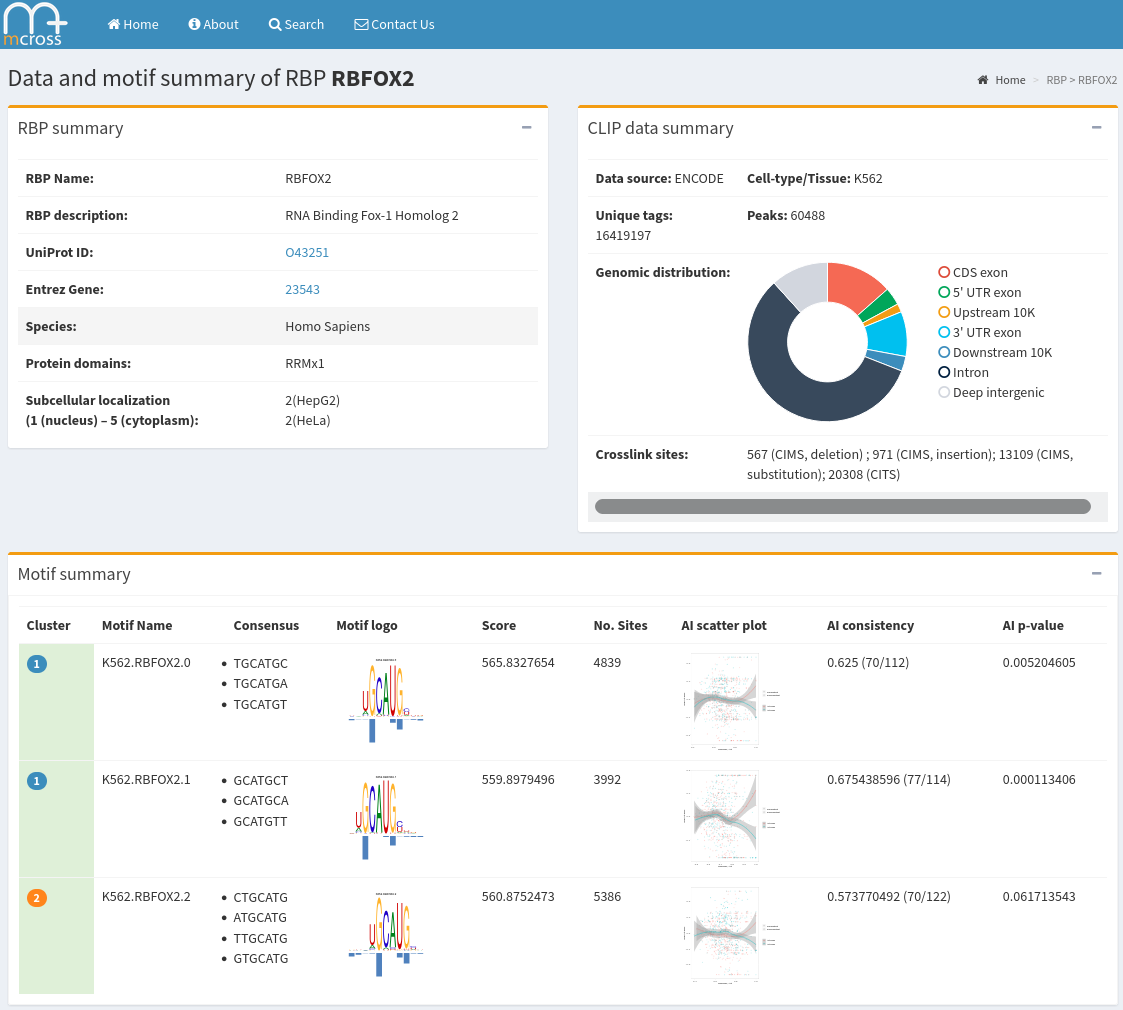

In [43]:
display(Image("../documentation/media/mcrossbase.rbfox2_example.png"))

/home/l10n/projects/ml4rg25-parnet/parnet_demo/.pixi/envs/parnet-demo/lib/python3.10/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zhanglab.c2b2.columbia.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


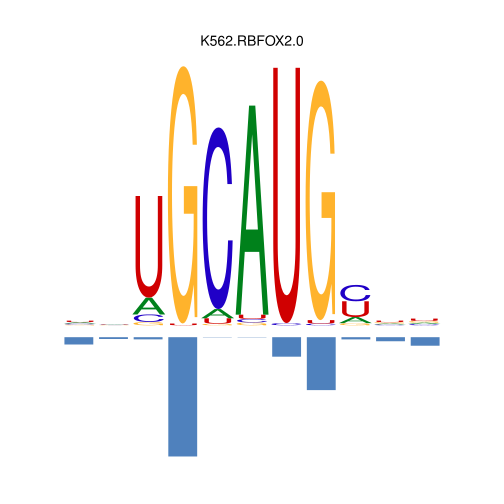

In [42]:
url = "https://zhanglab.c2b2.columbia.edu/mCrossBase/static/plots/logo/{CELLTYPE}.{RBP}.top10.cluster.m1.00.svg".format(
    RBP="RBFOX2", CELLTYPE="K562"
)
response = requests.get(url, verify=False)

display(SVG(response.content))

## Cleanup

In [ ]:
pbt.cleanup()